## Required Module Import

In [68]:
import torch
import pickle
import os
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.models import resnet50
from torchvision.datasets import Caltech101
from torch.nn.functional import normalize
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

## Dataset Loading and Preprocessing

In [62]:
transform = transforms.Compose([
    v2.RGB(),
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = Caltech101(root="data/", transform=transform, download=False)
dataset

Dataset Caltech101
    Number of datapoints: 8677
    Root location: data/caltech101
    Target type: ['category']
    StandardTransform
Transform: Compose(
               RGB()
               Resize(size=232, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [63]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=4)
dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.622571].


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


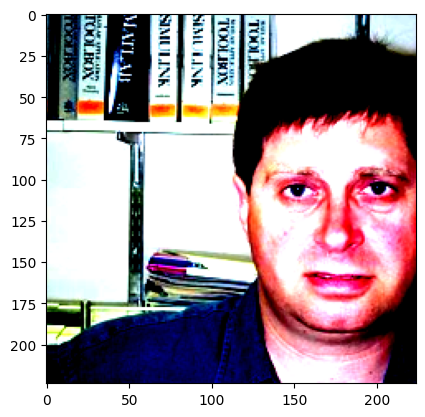

Label: 0


In [64]:
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

## Model

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
model = resnet50(weights="IMAGENET1K_V1") 
model = torch.nn.Sequential(*list(model.children())[:-1]) 
model.to(device)

for param in model.parameters():
    param.requires_grad = False

## Create Feature Vector

### Way - I: Single Image

In [42]:
def extract_features_per_image(image, model):
    model.eval()  
    image = image.unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        features = model(image)
    flattened_features = features.view(features.size(0), -1)
    normalized_features = normalize(flattened_features, p=2, dim=1)
    return normalized_features.squeeze()

In [43]:
res = extract_features_per_image(train_features[0], model)
res.shape

torch.Size([2048])

In [44]:
extensions = ['.jpg', '.jpeg', '.png'] 

def get_file_list(root_dir):
    file_list = []
    counter = 0
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    print(counter)
    return file_list

In [45]:
root_dir = './data/caltech101/'
filenames = sorted(get_file_list(root_dir))

len(filenames)

9144


9144

In [46]:
single_image_wise_feature_list = []
    
for i in tqdm(range(len(filenames))):
    image = Image.open(filenames[i]).convert('RGB')
    image = transform(image)
    features = extract_features_per_image(image, model)
    single_image_wise_feature_list.append(features.cpu())

100%|██████████| 9144/9144 [10:55<00:00, 13.95it/s]


In [47]:
len(single_image_wise_feature_list)

9144

### Way -II: Batch Wise

In [48]:
def extract_features_per_batch(batch_images, model):
    model.eval()
    batch_images = batch_images.to(device)
    with torch.no_grad():
        features = model(batch_images)
    flattened_features = features.view(features.size(0), -1)
    normalized_features = normalize(flattened_features, p=2, dim=1)
    return normalized_features

In [65]:
batch_wise_feature_list = []

for batch_images, _ in tqdm(dataloader, desc="Extracting Features"):
    batch_features = extract_features_per_batch(batch_images, model)
    batch_wise_feature_list.append(batch_features.cpu())

final_features = torch.cat(batch_wise_feature_list)

Extracting Features: 100%|██████████| 136/136 [35:21<00:00, 15.60s/it]


In [66]:
final_features.shape

torch.Size([8677, 2048])

## Save Pickle

In [69]:
pickle.dump(single_image_wise_feature_list, open('pickle/features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('pickle/filenames-caltech101.pickle','wb'))